# Linear Algebra and Applications in Economics
## Agenda

- Portfolios
- Unemployment Dynamics

## 参考

- [QuantEcon Applied Linear Algebra](https://datascience.quantecon.org/scientific/applied_linalg.html#exercise-1)

### Python

In [1]:
!python -V

Python 3.7.4


### Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Settings

In [3]:
plt.style.use('ggplot')

## 1. Portfolios

ここでmultiple asset porrfolioのNet Present Valueの評価を行う。

### 問題設定

まず二つの油田を買うことを検討しているとする。この油田をそれぞれA, Bと名付ける。このとき、

- 油田A, Bともに20年で枯渇してしまう
- 油田Aは初年度 5 unitの利益を生み出すことができるが、その後年々20%ずつ産出可能利益は減っていく(2年目は$5 \times 0.8$ unit)
- 油田Bは初年度 2 unitの利益を生み出すことができるが、その後年々10%ずつ産出可能利益は減っていく
- 割引率は5%とする
- 油田の購入価格はそれぞれ$P_A = P_B = 1$とする

ここでNPVをまとめると、

$$
\begin{aligned}
V_A &= \sum_{t=0}^{T-1} \left(\frac{1}{1 + r}\right)^t y^A_t = \sum_{t=0}^{T-1} \left(\frac{1}{1 + r}\right)^t (\, x_{A0}\, \gamma_A^t)\\
V_B &= \sum_{t=0}^{T-1} \left(\frac{1}{1 + r}\right)^t y^B_t = \sum_{t=0}^{T-1} \left(\frac{1}{1 + r}\right)^t (\, x_{B0}\, \gamma_B^t)\\
V &= V_A + V_B
\end{aligned}
$$

なお、$\gamma_A = 0.8, \gamma_B = 0.9$とする。これをNumpyを用いて計算する。

### Numpyを用いた計算

In [4]:
# Depreciation of production rates
gamma_A = 0.80
gamma_B = 0.90

# Interest rate discounting
r = 0.05
discount = np.array([(1 / (1+r))**t for t in range(20)])

# Let's first create arrays that have the production of each oilfield
oil_A = 5 * np.array([gamma_A**t for t in range(20)])
oil_B = 2 * np.array([gamma_B**t for t in range(20)])
oilfields = np.array([oil_A, oil_B])

In [5]:
discount.shape

(20,)

In [6]:
oilfields.shape

(2, 20)

In [7]:
# Use matrix multiplication to get discounted sum of oilfield values and then sum
# the two values
Vs = oilfields @ discount

print(f"The npv of oilfields is {Vs.sum()} and each NPV are {Vs}")

The npv of oilfields is 34.267256487477496 and each NPV are [20.90874996 13.35850653]


$T\to \infty$の場合は、上記のNPVを式変形し、

$$
V_A = \sum_{t=0}^{\infty}\left(\frac{1}{1 + r}\right)^t (x_{A0} \gamma_A^t) = x_{A0}\sum_{t=0}^{\infty}\left(\frac{\gamma_A}{1 + r}\right)^t =  \frac{x_{A0}}{1 - \left(\gamma_A\frac{1}{1 + r} \right)}
$$

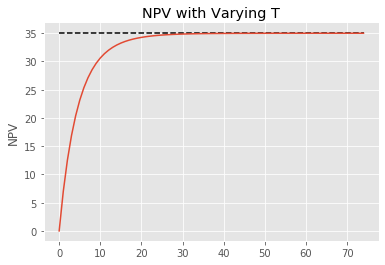

In [8]:
# Depreciation of production rates
gamma_A = 0.80
gamma_B = 0.90

# Interest rate discounting
r = 0.05


def infhor_NPV_oilfield(starting_output, gamma, r):
    beta = gamma / (1 + r)
    return starting_output / (1 - beta)


def compute_NPV_oilfield(starting_output, gamma, r, T):
    outputs = starting_output * np.array([gamma**t for t in range(T)])
    discount = np.array([(1 / (1+r))**t for t in range(T)])

    npv = np.dot(outputs, discount)

    return npv

Ts = np.arange(0, 75)

NPVs_A = np.array([compute_NPV_oilfield(5, gamma_A, r, t) for t in Ts])
NPVs_B = np.array([compute_NPV_oilfield(2, gamma_B, r, t) for t in Ts])

NPVs_T = NPVs_A + NPVs_B
NPV_oo = infhor_NPV_oilfield(5, gamma_A, r) + infhor_NPV_oilfield(2, gamma_B, r)

fig, ax = plt.subplots()

ax.set_title("NPV with Varying T")
ax.set_ylabel("NPV")

ax.plot(Ts, NPVs_A + NPVs_B)
ax.hlines(NPV_oo, Ts[0], Ts[-1], color="k", linestyle="--")  # Plot infinite horizon value

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

### 行列を用いた計算

NPVは以下のように記述することもできる：

$$
V = \sum_{t=0}^{\infty} \left(\left(\frac{1}{1 + r}\right)^t \begin{bmatrix} \gamma_A & 0 \\ 0 & \gamma_B \end{bmatrix}^t \cdot x_0\right)
$$

このとき、$x_0 = \begin{bmatrix} x_{A0} \\ x_{B0} \end{bmatrix}$

$A\equiv \begin{bmatrix} \gamma_A & 0 \\ 0 & \gamma_B \end{bmatrix}^t$とすると、

$$
V = G \sum_{t=0}^{\infty} \left(\frac{1}{1 + r}\right)^t A^t x_0
$$

$T\to \infty$の場合は、

$$
V = G \left(I - \frac{1}{1+r} A\right)^{-1} x_0 \tag{1}
$$

In [9]:
r = 0.05
beta = 1 / (1 + r)

gamma_A = 0.80
gamma_B = 0.90
A = np.array([[gamma_A, 0], [0, gamma_B]])

x_0 = np.array([5, 2])

# Compute with matrix formula
NPV_mf = np.linalg.inv(np.eye(2) - beta*A) @ x_0

print(np.sum(NPV_mf))

34.99999999999999


## 2. Unemployment Dynamics

- 失業者が$\phi = 10 %$の確率で雇用され、被雇用者が$\alpha = 5 %$の確率で失業するEconomyを考える。
- $x_0 = [900000, 100000]$がthe employedとthe unemployedのtime 0における人数とする

このEconomyにおける失業者、被雇用者の推移をplotしたいとする

In [10]:
phi = 0.1
alpha = 0.05

x0 = np.array([900_000, 100_000])

A = np.array([[1-alpha, alpha], [phi, 1-phi]])

def simulate(x0, A, T=10):
    """
    Simulate the dynamics of unemployment for T periods starting from x0
    and using values of A for probabilities of moving between employment
    and unemployment
    """
    nX = x0.shape[0]
    out = np.zeros((T, nX))
    out[0, :] = x0

    for t in range(1, T):
        out[t, :] = A.T @ out[t-1, :]

    return out

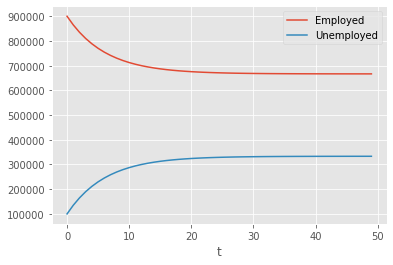

In [11]:
def plot_simulation(x0, A, T=100):
    X = simulate(x0, A, T)
    fig, ax = plt.subplots()
    ax.plot(X[:, 0])
    ax.plot(X[:, 1])
    ax.set_xlabel("t")
    ax.legend(["Employed", "Unemployed"])
    return ax

plot_simulation(x0, A, 50)

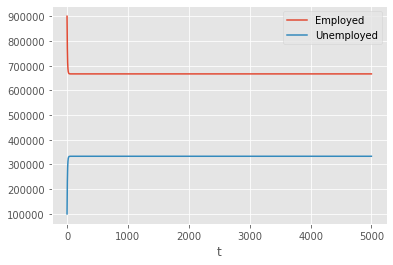

In [12]:
plot_simulation(x0, A, 5000)

これは固有値を用いて計算することができる

In [13]:
eigvals, eigvecs = np.linalg.eig(A.T)
for i in range(len(eigvals)):
    if eigvals[i] == 1:
        which_eig = i
        break

print(f"We are looking for eigenvalue {which_eig}")

We are looking for eigenvalue 0


In [14]:
dist = eigvecs[:, which_eig]

# need to divide by sum so it adds to 1
dist /= dist.sum()

print(f"The distribution of workers is given by {dist}")

The distribution of workers is given by [0.66666667 0.33333333]


In [15]:
eigen_res = sum(x0)*dist
naive_res = simulate(x0, A, 1000)[-1, :]
np.allclose(eigen_res, naive_res)

True